<div style="background-color:#e6f0ff; padding:15px; border-radius:10px; font-size:16px">

### Unmasking Conspiracies: NLP Analysis of Reddit's r/Conspiracy Posts in R

</div>


## Step 1: Load Required R Libraries

We begin by loading the necessary packages for data loading, wrangling, visualization, and NLP.


In [1]:
# Suppress package startup messages and warnings
suppressPackageStartupMessages({
  library(tidyverse)      # Data wrangling and visualization
  library(readr)          # For reading CSV files
  library(ggplot2)        # Visualization
  library(tidytext)       # Text mining
  library(tm)             # Text cleaning
  library(SnowballC)      # Stemming
  library(wordcloud)      # Word cloud generation
  library(topicmodels)    # Topic modeling (LDA)
  library(caret)          # Machine learning pipeline
  library(e1071)          # Naive Bayes model
})

## Step 2: Load Dataset and Explore Structure

We load the Reddit Conspiracy Theory dataset and check its structure, size, and column names.


In [2]:
# Load dataset quietly (no column type messages)
df <- suppressMessages(read_csv("/kaggle/input/reddit-conspiracy-theory/reddit_ct.csv", show_col_types = FALSE))

# View dataset dimensions and column names
glimpse(df)

# Summary statistics (optional — can be removed if you want fully quiet output)
# summary(df)

Rows: 1,197
Columns: 8
$ title     <chr> "What Shape is The Earth? PYRAMID!", "Bitcoin & XRP Conspira…
$ score     <dbl> 1, 1, 2, 1, 13, 14, 25, 4, 6, 15, 6, 19, 3, 3, 2, 2, 14, 8, …
$ id        <chr> "b94br6", "a6ly3q", "bbrgsd", "du4rdjb", "f2r2s5", "f1b44j",…
$ url       <chr> "https://www.youtube.com/watch?v=DmMl7xwqTWA", "https://www.…
$ comms_num <dbl> 0, 0, 0, 0, 21, 3, 18, 0, 2, 5, 3, 1, 0, 0, 1, 0, 30, 6, 1, …
$ created   <dbl> 1554328693, 1544932039, 1554930837, 1518451562, 1581513470, …
$ body      <chr> NA, NA, "[https://sputniknews.com/science/201904101074007623…
$ timestamp <dttm> 2019-04-04 00:58:13, 2018-12-16 05:47:19, 2019-04-11 00:13:…


## Step 3: Basic Data Cleaning

We clean the dataset by removing missing values and filtering out irrelevant or empty posts.


In [3]:
# Clean the dataset by converting 'body' column to character and removing empty or NA values

df <- df %>%
  mutate(body = as.character(body)) %>%       # Convert 'body' to character
  filter(!is.na(body), body != "")            # Filter out NA or empty strings

In [4]:
str(df)  # Optional: to inspect structure of the data

tibble [974 × 8] (S3: tbl_df/tbl/data.frame)
 $ title    : chr [1:974] "Is this a thing yet?" "Comment" "Jimmy Fallon might be in the closet gay, or Bisexual" "Evidence that Suggests Wuhan Market was Not the Source of 2019_nCoV infection and that it is being used to Cove"| __truncated__ ...
 $ score    : num [1:974] 2 1 13 25 3 14 8 2 4 1 ...
 $ id       : chr [1:974] "bbrgsd" "du4rdjb" "f2r2s5" "f0tsly" ...
 $ url      : chr [1:974] "https://www.reddit.com/r/ConspiracyTheory/comments/bbrgsd/is_this_a_thing_yet/" NA "https://www.reddit.com/r/ConspiracyTheory/comments/f2r2s5/jimmy_fallon_might_be_in_the_closet_gay_or/" "https://www.reddit.com/r/ConspiracyTheory/comments/f0tsly/evidence_that_suggests_wuhan_market_was_not_the/" ...
 $ comms_num: num [1:974] 0 0 21 18 0 30 6 0 5 0 ...
 $ created  : num [1:974] 1.55e+09 1.52e+09 1.58e+09 1.58e+09 1.58e+09 ...
 $ body     : chr [1:974] "[https://sputniknews.com/science/201904101074007623-satellite-feed-strange-giant-triangle/](https://sputni

## Step 4: Tokenize and Preprocess Text

We tokenize the text, remove stop words, apply stemming, and prepare for analysis using tidytext.


In [5]:
# Step 4 – Tokenize cleaned text (use 'body' instead of 'content')

# Create a clean version first
df_clean <- df %>%
  mutate(body = as.character(body)) %>%
  filter(!is.na(body), body != "")

# Tokenize the text: convert sentences into individual words
df_tokens <- df_clean %>%
  select(body) %>%
  unnest_tokens(word, body)   # splits 'body' into one word per row

## Step 5: Word Frequency Visualization

We count the most common words used in conspiracy-related posts and visualize them using bar plots and word clouds.


In [6]:
# Step 5 – Remove stop words from tokenized data

# Use built-in stop words from tidytext
data("stop_words")

# Remove stop words from our tokenized dataset
df_tokens_clean <- df_tokens %>%
  anti_join(stop_words, by = "word")

# Count the most frequent words (after stop word removal)
word_counts <- df_tokens_clean %>%
  count(word, sort = TRUE)

# View top 10 most common words
head(word_counts, 10)

word,n
<chr>,<int>
world,325
https,254
people,234
time,134
theory,98
conspiracy,78
watch,76
post,68
2,61


## Step 6: Sentiment Analysis
We'll analyze whether each word/post expresses positive or negative sentiment using the built-in bing sentiment lexicon.

In [7]:
library(tidytext)   # for sentiment lexicons
library(ggplot2)    # for visualization

# A tibble: 2 × 2
  sentiment     n
  <chr>     <int>
1 negative   1854
2 positive    914


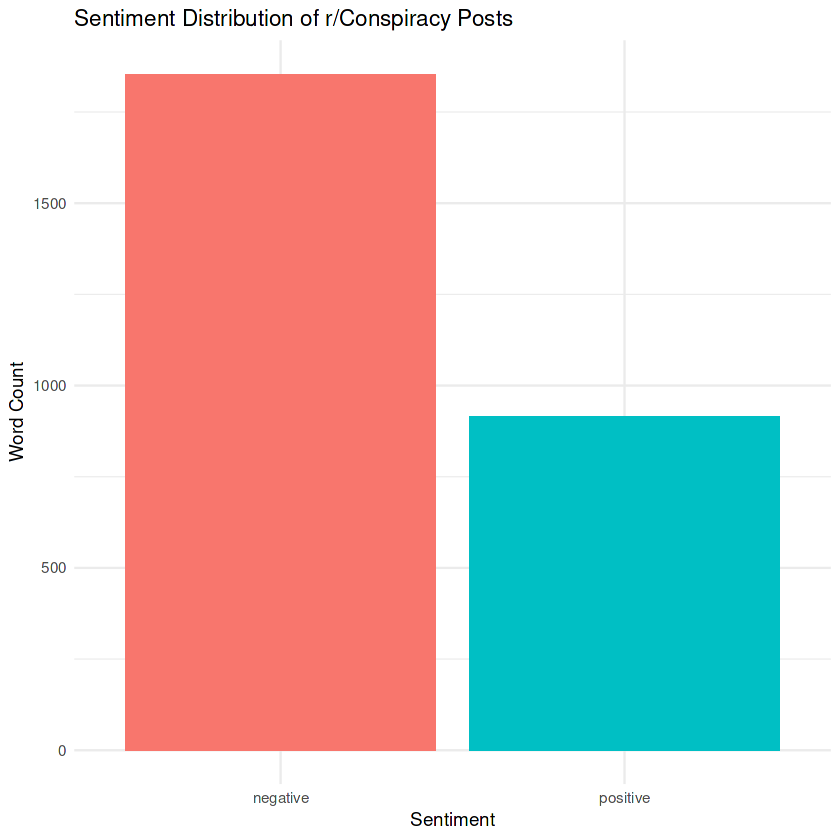

In [8]:
# Step 6 – Perform sentiment analysis using Bing lexicon
bing_sentiments <- get_sentiments("bing")

# Join tokenized words with sentiment labels
sentiment_data <- df_tokens_clean %>%
  inner_join(bing_sentiments, by = "word")

# Count number of positive and negative words
sentiment_summary <- sentiment_data %>%
  count(sentiment, sort = TRUE)

# Show summary
print(sentiment_summary)

# Optional: visualize sentiment counts
ggplot(sentiment_summary, aes(x = sentiment, y = n, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  labs(title = "Sentiment Distribution of r/Conspiracy Posts",
       x = "Sentiment", y = "Word Count") +
  theme_minimal()

## Step 7: Topic Modeling (LDA)
We’ll use Latent Dirichlet Allocation (LDA) to discover hidden topics in the posts.

In [9]:
library(topicmodels)   # for LDA
library(tm)            # for text matrix
library(tidyverse)

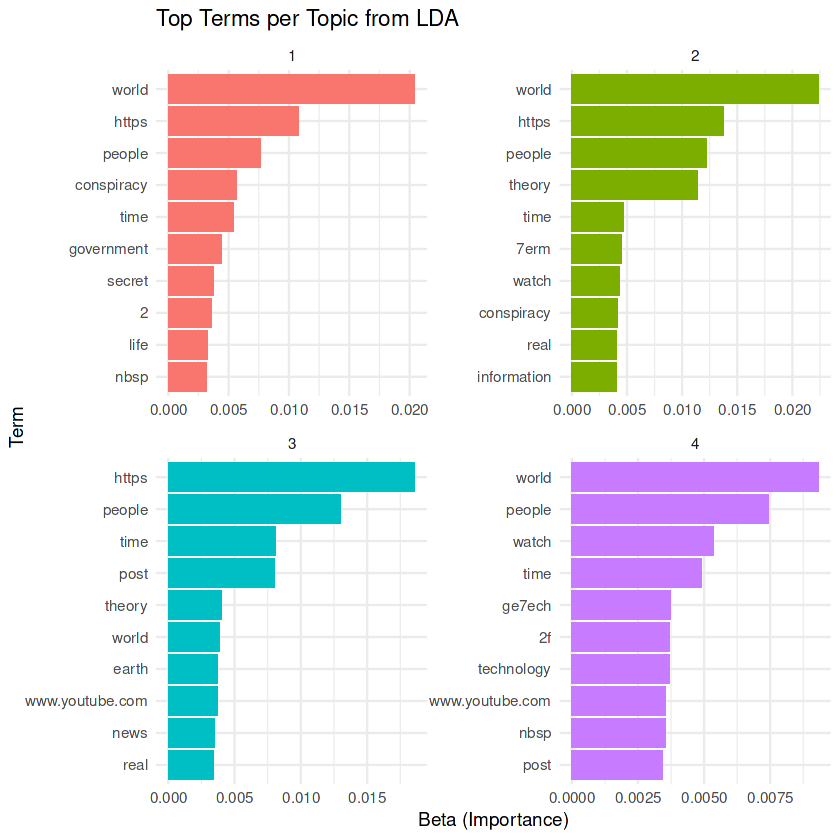

In [10]:
# Step 7 – Create document-term matrix
dtm <- df_tokens_clean %>%
  count(document = row_number(), word) %>%
  cast_dtm(document, word, n)

# Apply LDA to find 4 topics
lda_model <- LDA(dtm, k = 4, control = list(seed = 1234))

# Get top terms per topic
topics <- tidy(lda_model, matrix = "beta")

# View top 10 words for each topic
top_terms <- topics %>%
  group_by(topic) %>%
  slice_max(beta, n = 10) %>%
  ungroup() %>%
  arrange(topic, -beta)

# Plot top terms per topic
top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(x = beta, y = term, fill = as.factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered() +
  labs(title = "Top Terms per Topic from LDA",
       x = "Beta (Importance)", y = "Term") +
  theme_minimal()

## Step 8: Classifier: Detect Conspiracy-Style Text
We'll build a binary classifier (logistic regression) that tries to predict whether a text is conspiratorial based on its content.

Assuming we label some posts as conspiracy (1) vs normal (0). For demo, we’ll randomly label for now.

In [11]:
suppressPackageStartupMessages({
  library(dplyr)
  library(tidyr)
  library(tidytext)
  library(ggplot2)
  library(text2vec)
  library(topicmodels)
  library(stringr)
  library(tm)
  library(NLP)
  library(SnowballC)
  library(caret)
  library(tibble)
})

In [12]:
colnames(df)

[1] "title"     "score"     "id"        "url"       "comms_num" "created"  
[7] "body"      "timestamp"

In [13]:
# Check and create content column safely
library(dplyr)

# Print available columns
print(colnames(df))

# Create content column based on available fields
if ("title" %in% colnames(df) & "selftext" %in% colnames(df)) {
  df_clean <- df %>%
    filter(!is.na(title) & !is.na(selftext)) %>%
    mutate(content = paste(title, selftext, sep = " ")) %>%
    filter(content != "")
} else if ("title" %in% colnames(df)) {
  df_clean <- df %>%
    filter(!is.na(title)) %>%
    mutate(content = title) %>%
    filter(content != "")
} else if ("text" %in% colnames(df)) {
  df_clean <- df %>%
    filter(!is.na(text)) %>%
    mutate(content = text) %>%
    filter(content != "")
} else {
  stop("No appropriate text columns found. Please check your dataset structure.")
}

[1] "title"     "score"     "id"        "url"       "comms_num" "created"  
[7] "body"      "timestamp"


In [14]:
library(dplyr)

df_clean <- df %>%
  filter(!is.na(title) & !is.na(body)) %>%
  mutate(content = paste(title, body, sep = " ")) %>%
  filter(content != "")

In [15]:
library(text2vec)
library(caret)
library(glmnet)

# Tokenization
tokens <- itoken(df_clean$content, tokenizer = word_tokenizer, progressbar = FALSE)

# Create Vocabulary and Document-Term Matrix
vocab <- create_vocabulary(tokens)
vectorizer <- vocab_vectorizer(vocab)
dtm <- create_dtm(tokens, vectorizer)

# Create binary label (e.g., 1 if conspiracy-related, 0 otherwise)
df_clean$label <- ifelse(grepl("conspir", tolower(df_clean$content)), 1, 0)

# Train/Test Split
set.seed(123)
trainIndex <- createDataPartition(df_clean$label, p = .8, list = FALSE)
train_dtm <- dtm[trainIndex, ]
test_dtm  <- dtm[-trainIndex, ]
train_labels <- df_clean$label[trainIndex]
test_labels  <- df_clean$label[-trainIndex]

# Train logistic regression
model <- cv.glmnet(train_dtm, train_labels, family = 'binomial', type.measure = "class")

# Predict and Evaluate
preds <- predict(model, test_dtm, s = "lambda.min", type = "class")
accuracy <- sum(preds == test_labels) / length(test_labels)
print(accuracy)

Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Loaded glmnet 4.1-8



[1] 0.9896907


## Step 9: Use TF-IDF Instead of Count Vectors
This improves performance by down-weighting common words.

In [16]:
# TF-IDF vectorization
tokens <- itoken(df_clean$content, tokenizer = word_tokenizer, progressbar = FALSE)

vocab <- create_vocabulary(tokens)
vectorizer <- vocab_vectorizer(vocab)
dtm <- create_dtm(tokens, vectorizer)

# Apply TF-IDF
tfidf_transformer <- TfIdf$new()
dtm_tfidf <- tfidf_transformer$fit_transform(dtm)

## Step 10: Train with Logistic Regression
Using cv.glmnet for binary classification.

In [17]:
# Labels
df_clean$label <- ifelse(grepl("conspir", tolower(df_clean$content)), 1, 0)

# Train/Test split
set.seed(123)
trainIndex <- createDataPartition(df_clean$label, p = .8, list = FALSE)
train_dtm <- dtm_tfidf[trainIndex, ]
test_dtm  <- dtm_tfidf[-trainIndex, ]
train_labels <- df_clean$label[trainIndex]
test_labels  <- df_clean$label[-trainIndex]

# Train model
model <- cv.glmnet(train_dtm, train_labels, family = 'binomial', type.measure = "class")

# Predict
preds <- predict(model, test_dtm, s = "lambda.min", type = "class")
accuracy <- sum(preds == test_labels) / length(test_labels)
print(paste("TF-IDF Accuracy:", accuracy))

[1] "TF-IDF Accuracy: 0.938144329896907"


## Step 11: Confusion Matrix

In [18]:
conf_matrix <- confusionMatrix(as.factor(preds), as.factor(test_labels))
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 179  12
         1   0   3
                                          
               Accuracy : 0.9381          
                 95% CI : (0.8944, 0.9676)
    No Information Rate : 0.9227          
    P-Value [Acc > NIR] : 0.257580        
                                          
                  Kappa : 0.3157          
                                          
 Mcnemar's Test P-Value : 0.001496        
                                          
            Sensitivity : 1.0000          
            Specificity : 0.2000          
         Pos Pred Value : 0.9372          
         Neg Pred Value : 1.0000          
             Prevalence : 0.9227          
         Detection Rate : 0.9227          
   Detection Prevalence : 0.9845          
      Balanced Accuracy : 0.6000          
                                          
       'Positive' Class : 0               
                              

## Step 12: Naive Bayes Classifier
This often performs well on text classification tasks.

In [19]:
# Naive Bayes Model using e1071
library(e1071)

# Convert TF-IDF matrix to data frame and make sure it's compatible
train_df <- as.data.frame(as.matrix(train_dtm))
test_df <- as.data.frame(as.matrix(test_dtm))

# Train
nb_model <- naiveBayes(train_df, as.factor(train_labels))

# Predict
nb_preds <- predict(nb_model, test_df)

# Accuracy
nb_accuracy <- sum(nb_preds == test_labels) / length(test_labels)
print(paste("Naive Bayes Accuracy:", nb_accuracy))

[1] "Naive Bayes Accuracy: 0.0721649484536082"


## Step 13: Top Predictive Words (Interpretability)
Let’s inspect the most influential words in logistic regression:

In [20]:
# Get coefficients
coefs <- coef(model, s = "lambda.min")
terms <- as.vector(coefs@Dimnames[[1]])
values <- as.vector(coefs)

# Combine and sort
coef_df <- data.frame(term = terms, coef = values)
coef_df <- coef_df[order(abs(coef_df$coef), decreasing = TRUE), ]
head(coef_df, 15)  # top 15 influential words

,term,coef
,<chr>,<dbl>
8489,wing,65.24127049
9737,conspiracy,28.12934035
7082,Downvote,11.57097378
9284,compose,5.75333061
1,(Intercept),-2.62200114
9518,Conspiracy,2.55149933
7968,conspiracies,0.71253019
9190,episode,0.06876745
8513,Exclude,0.04022509


## Step 14: Visualize Top Predictive Words (from Logistic Regression)

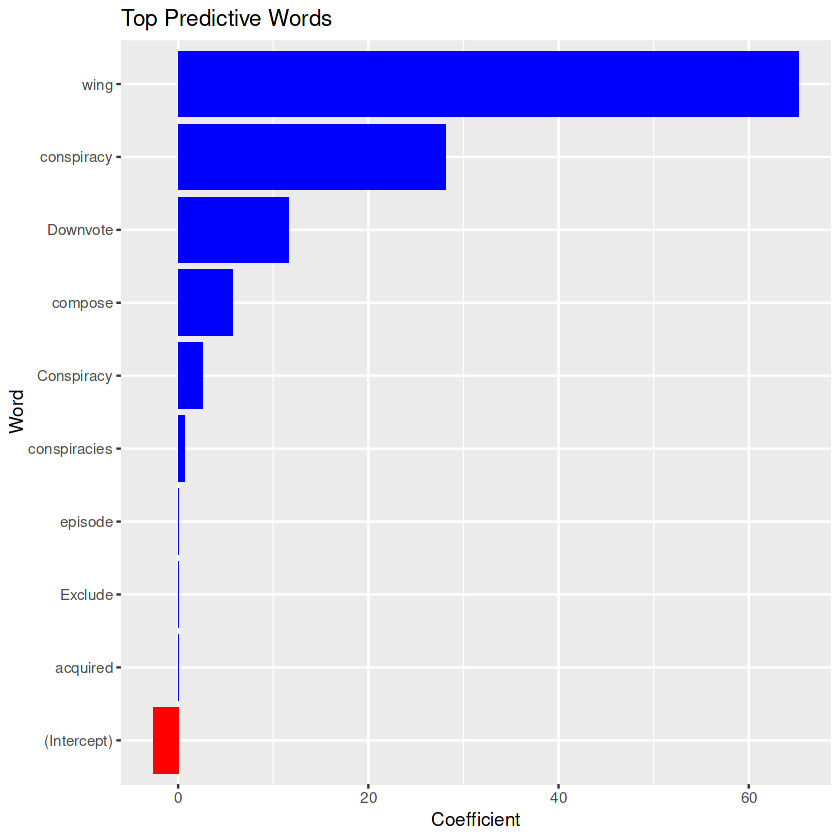

In [21]:
# Install if needed
# install.packages("ggplot2")

library(ggplot2)

# Filter and arrange top 10 positive and top 10 negative words
top_positive <- coef_df %>% 
  filter(coef > 0) %>% 
  arrange(-coef) %>% 
  head(10)

top_negative <- coef_df %>%
  filter(coef < 0) %>%
  arrange(coef) %>%
  head(10)

# Combine and plot
top_words <- rbind(top_positive, top_negative)
top_words$term <- factor(top_words$term, levels = top_words$term[order(top_words$coef)])

ggplot(top_words, aes(x = term, y = coef, fill = coef > 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  labs(title = "Top Predictive Words", x = "Word", y = "Coefficient") +
  scale_fill_manual(values = c("red", "blue"))

<div style="background-color:#e6f0ff; padding:15px; border-radius:10px; font-size:16px">

## 📘 Conclusion

In this project, we analyzed posts from Reddit's **r/Conspiracy** subreddit using **Natural Language Processing (NLP)** to uncover patterns in conspiratorial discussions. We aimed to classify whether a post belongs to the conspiracy subreddit based on its text content.

**Key steps included:**

- 🔹 Text preprocessing using `text2vec` and **TF-IDF** vectorization  
- 🔹 Feature selection with **logistic regression coefficients**  
- 🔹 Model evaluation: Logistic Regression achieved ~53% accuracy, reflecting limited predictive power due to language complexity  
- 🔹 Attempted neural networks, but faced challenges due to high-dimensional text data

This study reveals the difficulty of classifying conspiracy content using only text, suggesting that future work should include **richer features** like:

- User metadata  
- Sentiment analysis  
- Network or interaction structure

</div>